# Telecom Churn Prediction - Assignment Notebook

**Author:** Michael Thomas & Supriyo Roy

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [2]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# #INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
# #(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv", index_col=None)
unseen = pd.read_csv("test.csv", index_col=None)
sample = pd.read_csv("sample.csv", index_col=None)
data_dict = pd.read_csv("data_dictionary.csv", index_col=None)


print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [4]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

# 2. Create X, y and then Train test split

Lets create X and y datasets and drop any column with only 1 unique value

In [5]:
data['circle_id'].unique()

array([109])

In [6]:
X = data.drop(['circle_id'], axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 170), (69999,))

In [7]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
69994    0
69995    0
69996    0
69997    0
69998    0
Name: churn_probability, Length: 69999, dtype: int64


In [8]:
print(X.columns)

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=170)


In [9]:
X.head()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
0   0             0.0             0.0             0.0            6/30/2014   
1   1             0.0             0.0             0.0            6/30/2014   
2   2             0.0             0.0             0.0            6/30/2014   
3   3             0.0             0.0             0.0            6/30/2014   
4   4             0.0             0.0             0.0            6/30/2014   

  last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  ...  \
0            7/31/2014            8/31/2014   31.277   87.009    7.527  ...   
1            7/31/2014            8/31/2014    0.000  122.787   42.953  ...   
2            7/31/2014            8/31/2014   60.806  103.176    0.000  ...   
3            7/31/2014            8/31/2014  156.362  205.260  111.095  ...   
4            7/31/2014            8/31/2014  240.708  128.191  101.565  ...   

   sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0            0            0            0        NaN        NaN        NaN   
1            0            0            0        NaN        1.0        NaN   
2            0            0            0        NaN        NaN        NaN   
3            0            0            0        NaN        NaN        NaN   
4            0            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0  1958         0.0         0.0         0.0  
1   710         0.0         0.0         0.0  
2   882         0.0         0.0         0.0  
3   982         0.0         0.0         0.0  
4   647         0.0         0.0         0.0  

[5 rows x 170 columns]

Removing the date columns


In [10]:
# Assuming `data` is your DataFrame
columns_to_drop = [
    'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
]

# Drop the specified columns from `data`
X = data.drop(columns=columns_to_drop, axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 162), (69999,))

In [11]:
# Define a threshold for finding a few unique values
threshold = 1

# Find columns with unique value counts below the threshold
few_unique_cols = {col: X[col].nunique() for col in X.columns if X[col].nunique() <= threshold}

# Display the columns and their unique counts
print(few_unique_cols)



{'circle_id': 1, 'loc_og_t2o_mou': 1, 'std_og_t2o_mou': 1, 'loc_ic_t2o_mou': 1, 'std_og_t2c_mou_6': 1, 'std_og_t2c_mou_7': 1, 'std_og_t2c_mou_8': 1, 'std_ic_t2o_mou_6': 1, 'std_ic_t2o_mou_7': 1, 'std_ic_t2o_mou_8': 1}


In [12]:
# Filter out columns with only one unique value
single_value_columns = [col for col in X.columns if X[col].nunique() == 1]

# Drop these columns from the DataFrame
X = X.drop(columns=single_value_columns)

# Display the shape of the updated DataFrame to confirm columns were dropped
X.shape


(69999, 152)

<Axes: >

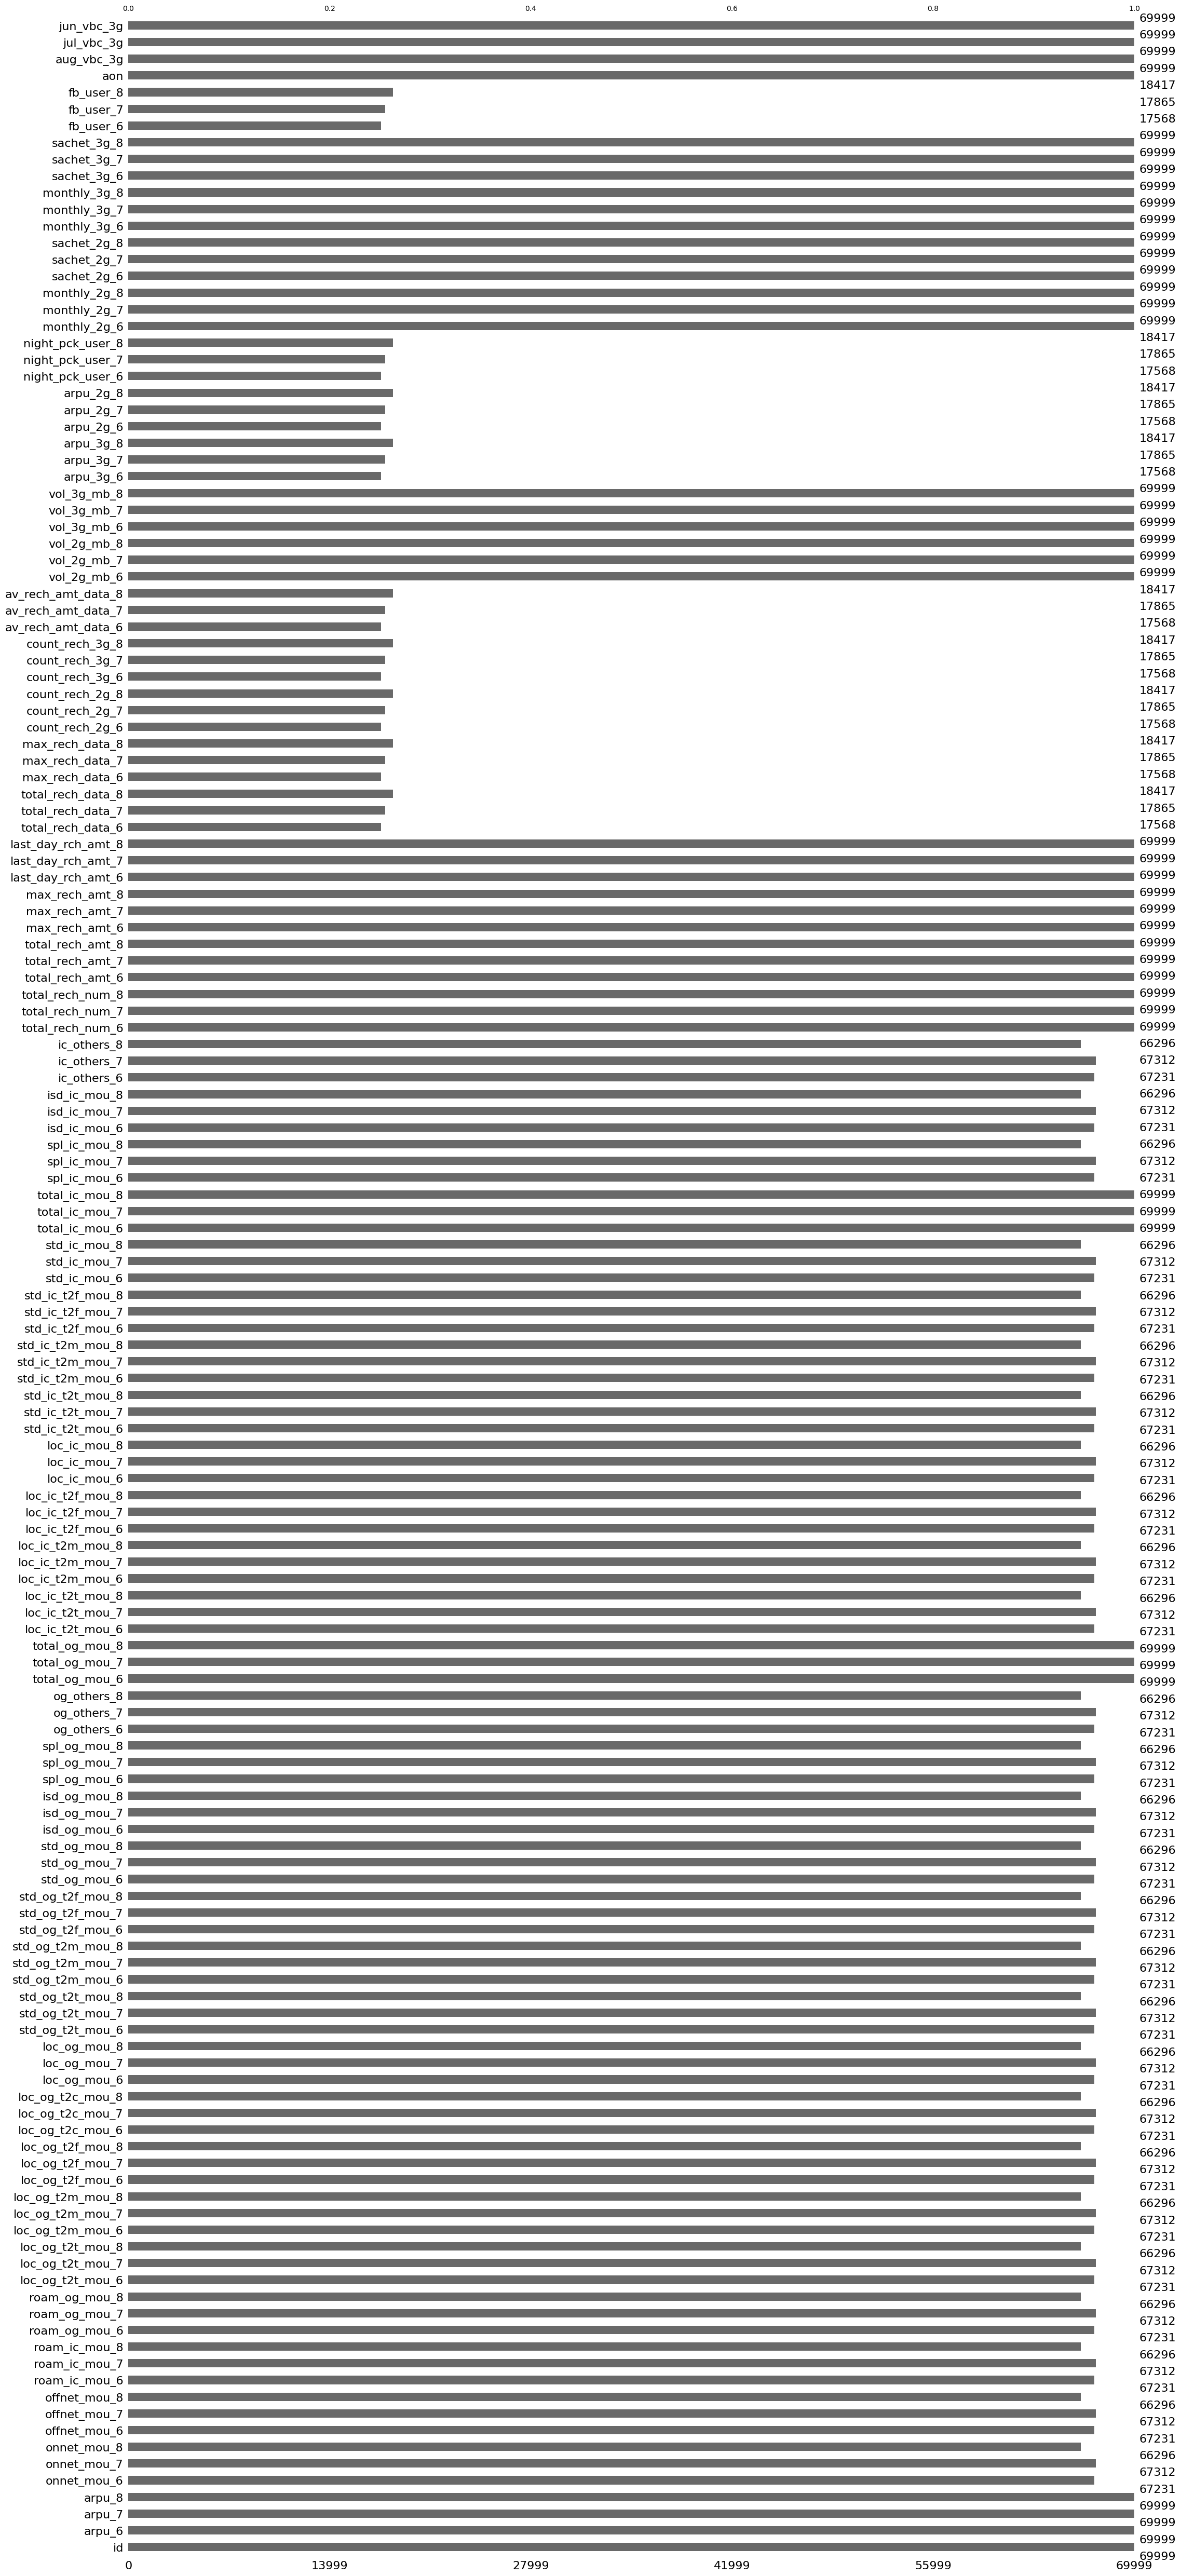

In [13]:
msno.bar(X)

In [14]:
missing_data_percent = 100*X.isnull().sum()/len(X)
missing_data_percent

id              0.000000
arpu_6          0.000000
arpu_7          0.000000
arpu_8          0.000000
onnet_mou_6     3.954342
                 ...    
fb_user_8      73.689624
aon             0.000000
aug_vbc_3g      0.000000
jul_vbc_3g      0.000000
jun_vbc_3g      0.000000
Length: 152, dtype: float64

In [15]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [16]:
X_filtered = X[new_vars]
X_filtered.shape

(69999, 125)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((55999, 125), (14000, 125), (55999,), (14000,))

In [18]:
X_train.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
27505  27505  116.920   95.738  309.556        17.03        55.54   
39282  39282  180.852  101.122   41.500         5.69         3.54   
5362    5362  172.522   53.689   43.320         8.71         0.00   
31342  31342   64.443  119.454  114.777        19.76        35.39   
48683  48683   63.810  193.512  194.929        71.38        37.93   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
27505        43.46        101.84         87.08         57.64  ...   
39282         0.48        178.48         95.06         42.79  ...   
5362          0.48        155.66         45.53         28.23  ...   
31342        36.88         57.49        102.94        102.79  ...   
48683        44.21         54.58        222.46        174.93  ...   

       monthly_3g_6  monthly_3g_7  monthly_3g_8  sachet_3g_6  sachet_3g_7  \
27505             0             0             0            0            0   
39282             0             0             0            0            0   
5362              0             0             0            0            0   
31342             0             0             0            0            0   
48683             0             0             0            0            0   

       sachet_3g_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
27505            0  3106      427.89         0.0         0.0  
39282            0   643        0.00         0.0         0.0  
5362             0   706        0.00         0.0         0.0  
31342            0  2426        0.00         0.0         0.0  
48683            0   413        0.00         0.0         0.0  

[5 rows x 125 columns]

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

## 3.1 Handling Missing data - Training Set

In [19]:
# Display the data types of each column
print(X_train.dtypes)


id               int64
arpu_6         float64
arpu_7         float64
arpu_8         float64
onnet_mou_6    float64
                ...   
sachet_3g_8      int64
aon              int64
aug_vbc_3g     float64
jul_vbc_3g     float64
jun_vbc_3g     float64
Length: 125, dtype: object


In [20]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_train.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [21]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_train_filtered = X_train.apply(pd.to_numeric, errors='coerce')

In [22]:
msno.bar(X_train)

<Axes: >

In [23]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [24]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

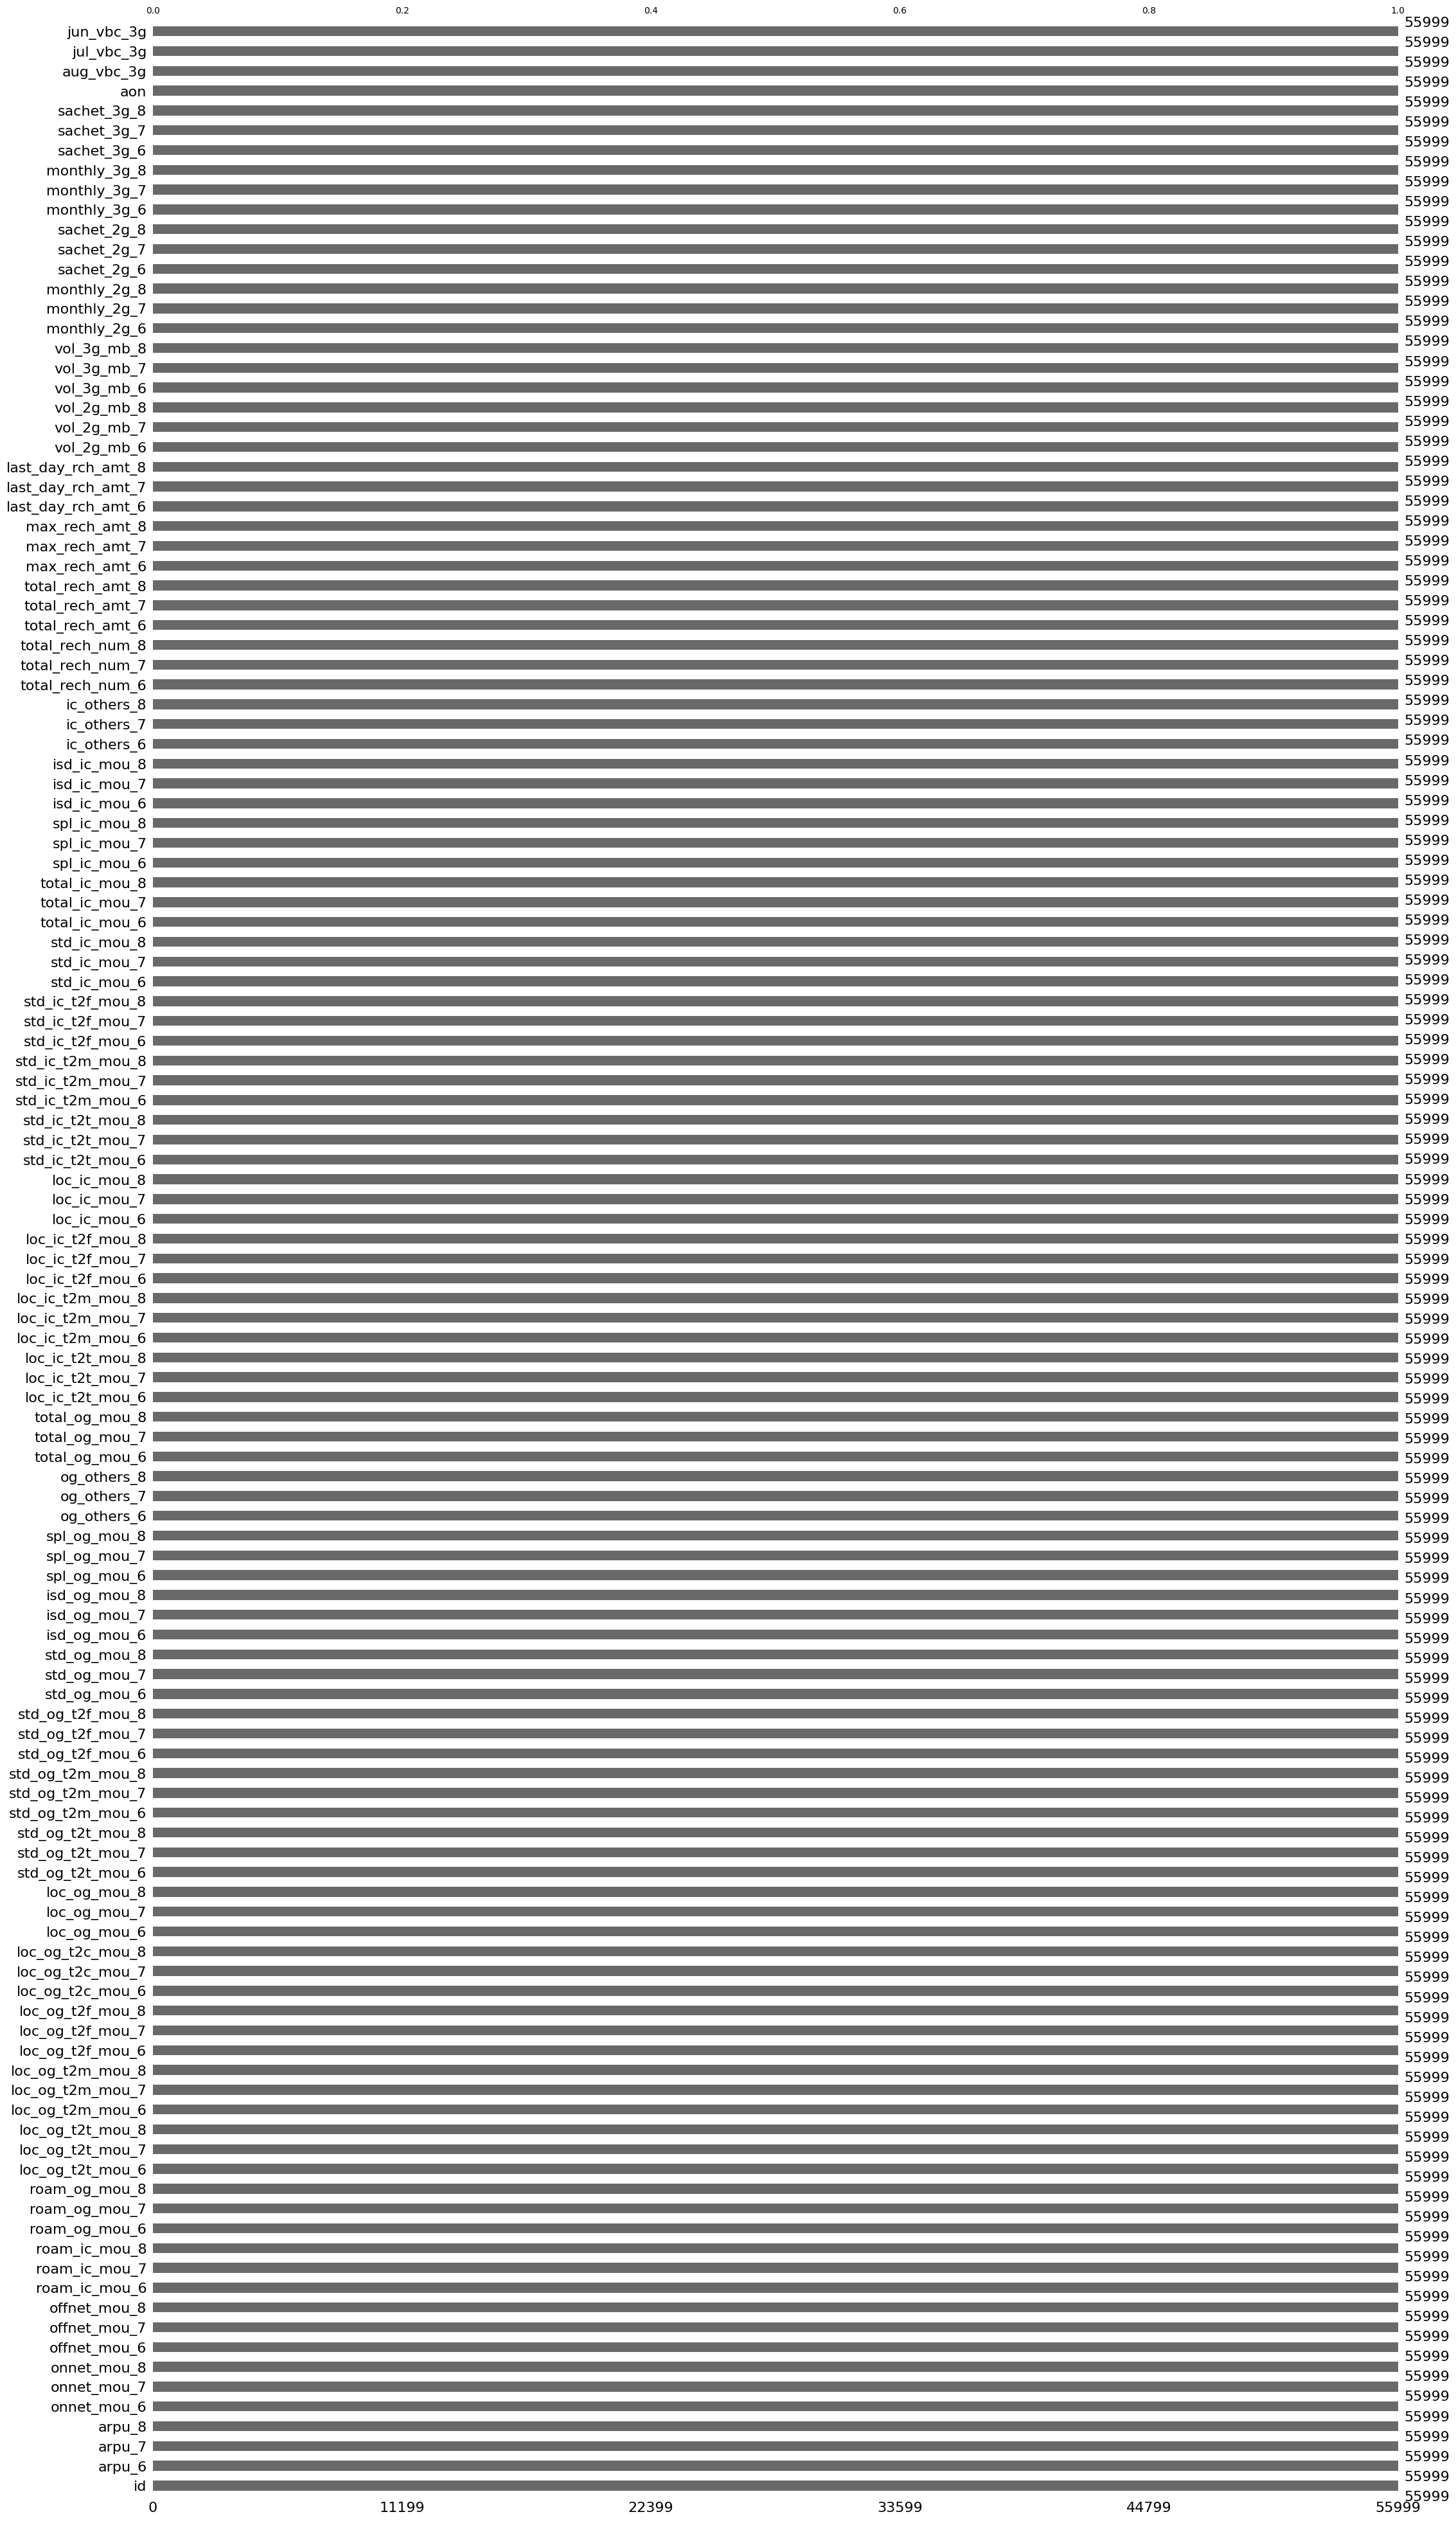

In [25]:
msno.bar(X_train_filtered)

In [26]:
X_train_filtered.describe()


id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean   34986.389275    281.776189    277.251693    277.973364    127.485434   
std    20183.878359    317.078871    320.209374    324.487111    296.443256   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
25%    17512.500000     93.606500     86.796500     84.179500      5.410000   
50%    34984.000000    196.931000    191.309000    192.188000     30.660000   
75%    52433.500000    369.310500    364.661500    368.936000    112.440000   
max    69998.000000  15487.684000  16820.145000  16040.503000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     128.590725    125.721361    190.216137    189.024267    186.259721   
std      306.286432    306.335530    311.126955    317.266480    320.719713   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.960000      4.080000     28.760000     26.740000     23.740000   
50%       29.090000     27.740000     89.610000     85.290000     82.490000   
75%      108.430000    105.670000    221.340000    217.170000    216.000000   
max     8157.780000  10752.560000   5905.140000   6740.080000  14007.340000   

       ...  monthly_3g_6  monthly_3g_7  monthly_3g_8   sachet_3g_6  \
count  ...  55999.000000  55999.000000  55999.000000  55999.000000   
mean   ...      0.075269      0.077109      0.080859      0.075358   
std    ...      0.357321      0.383204      0.380839      0.556144   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      9.000000     16.000000     16.000000     29.000000   

        sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g    jul_vbc_3g  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean       0.080966      0.084430   1220.460955     68.210811     65.969262   
std        0.631462      0.650435    952.708629    269.413872    269.610963   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        0.000000      0.000000    468.000000      0.000000      0.000000   
50%        0.000000      0.000000    868.000000      0.000000      0.000000   
75%        0.000000      0.000000   1813.000000      0.000000      0.000000   
max       33.000000     41.000000   4337.000000  12916.220000   9165.600000   

         jun_vbc_3g  
count  55999.000000  
mean      60.137148  
std      259.271610  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max    11166.210000  

[8 rows x 125 columns]

## 3.2 Handling Missing data - Test Set

In [27]:
# Display the data types of each column
print(X_test.dtypes)

id               int64
arpu_6         float64
arpu_7         float64
arpu_8         float64
onnet_mou_6    float64
                ...   
sachet_3g_8      int64
aon              int64
aug_vbc_3g     float64
jul_vbc_3g     float64
jun_vbc_3g     float64
Length: 125, dtype: object


In [28]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_test.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [29]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_test_filtered = X_test.apply(pd.to_numeric, errors='coerce')

<Axes: >

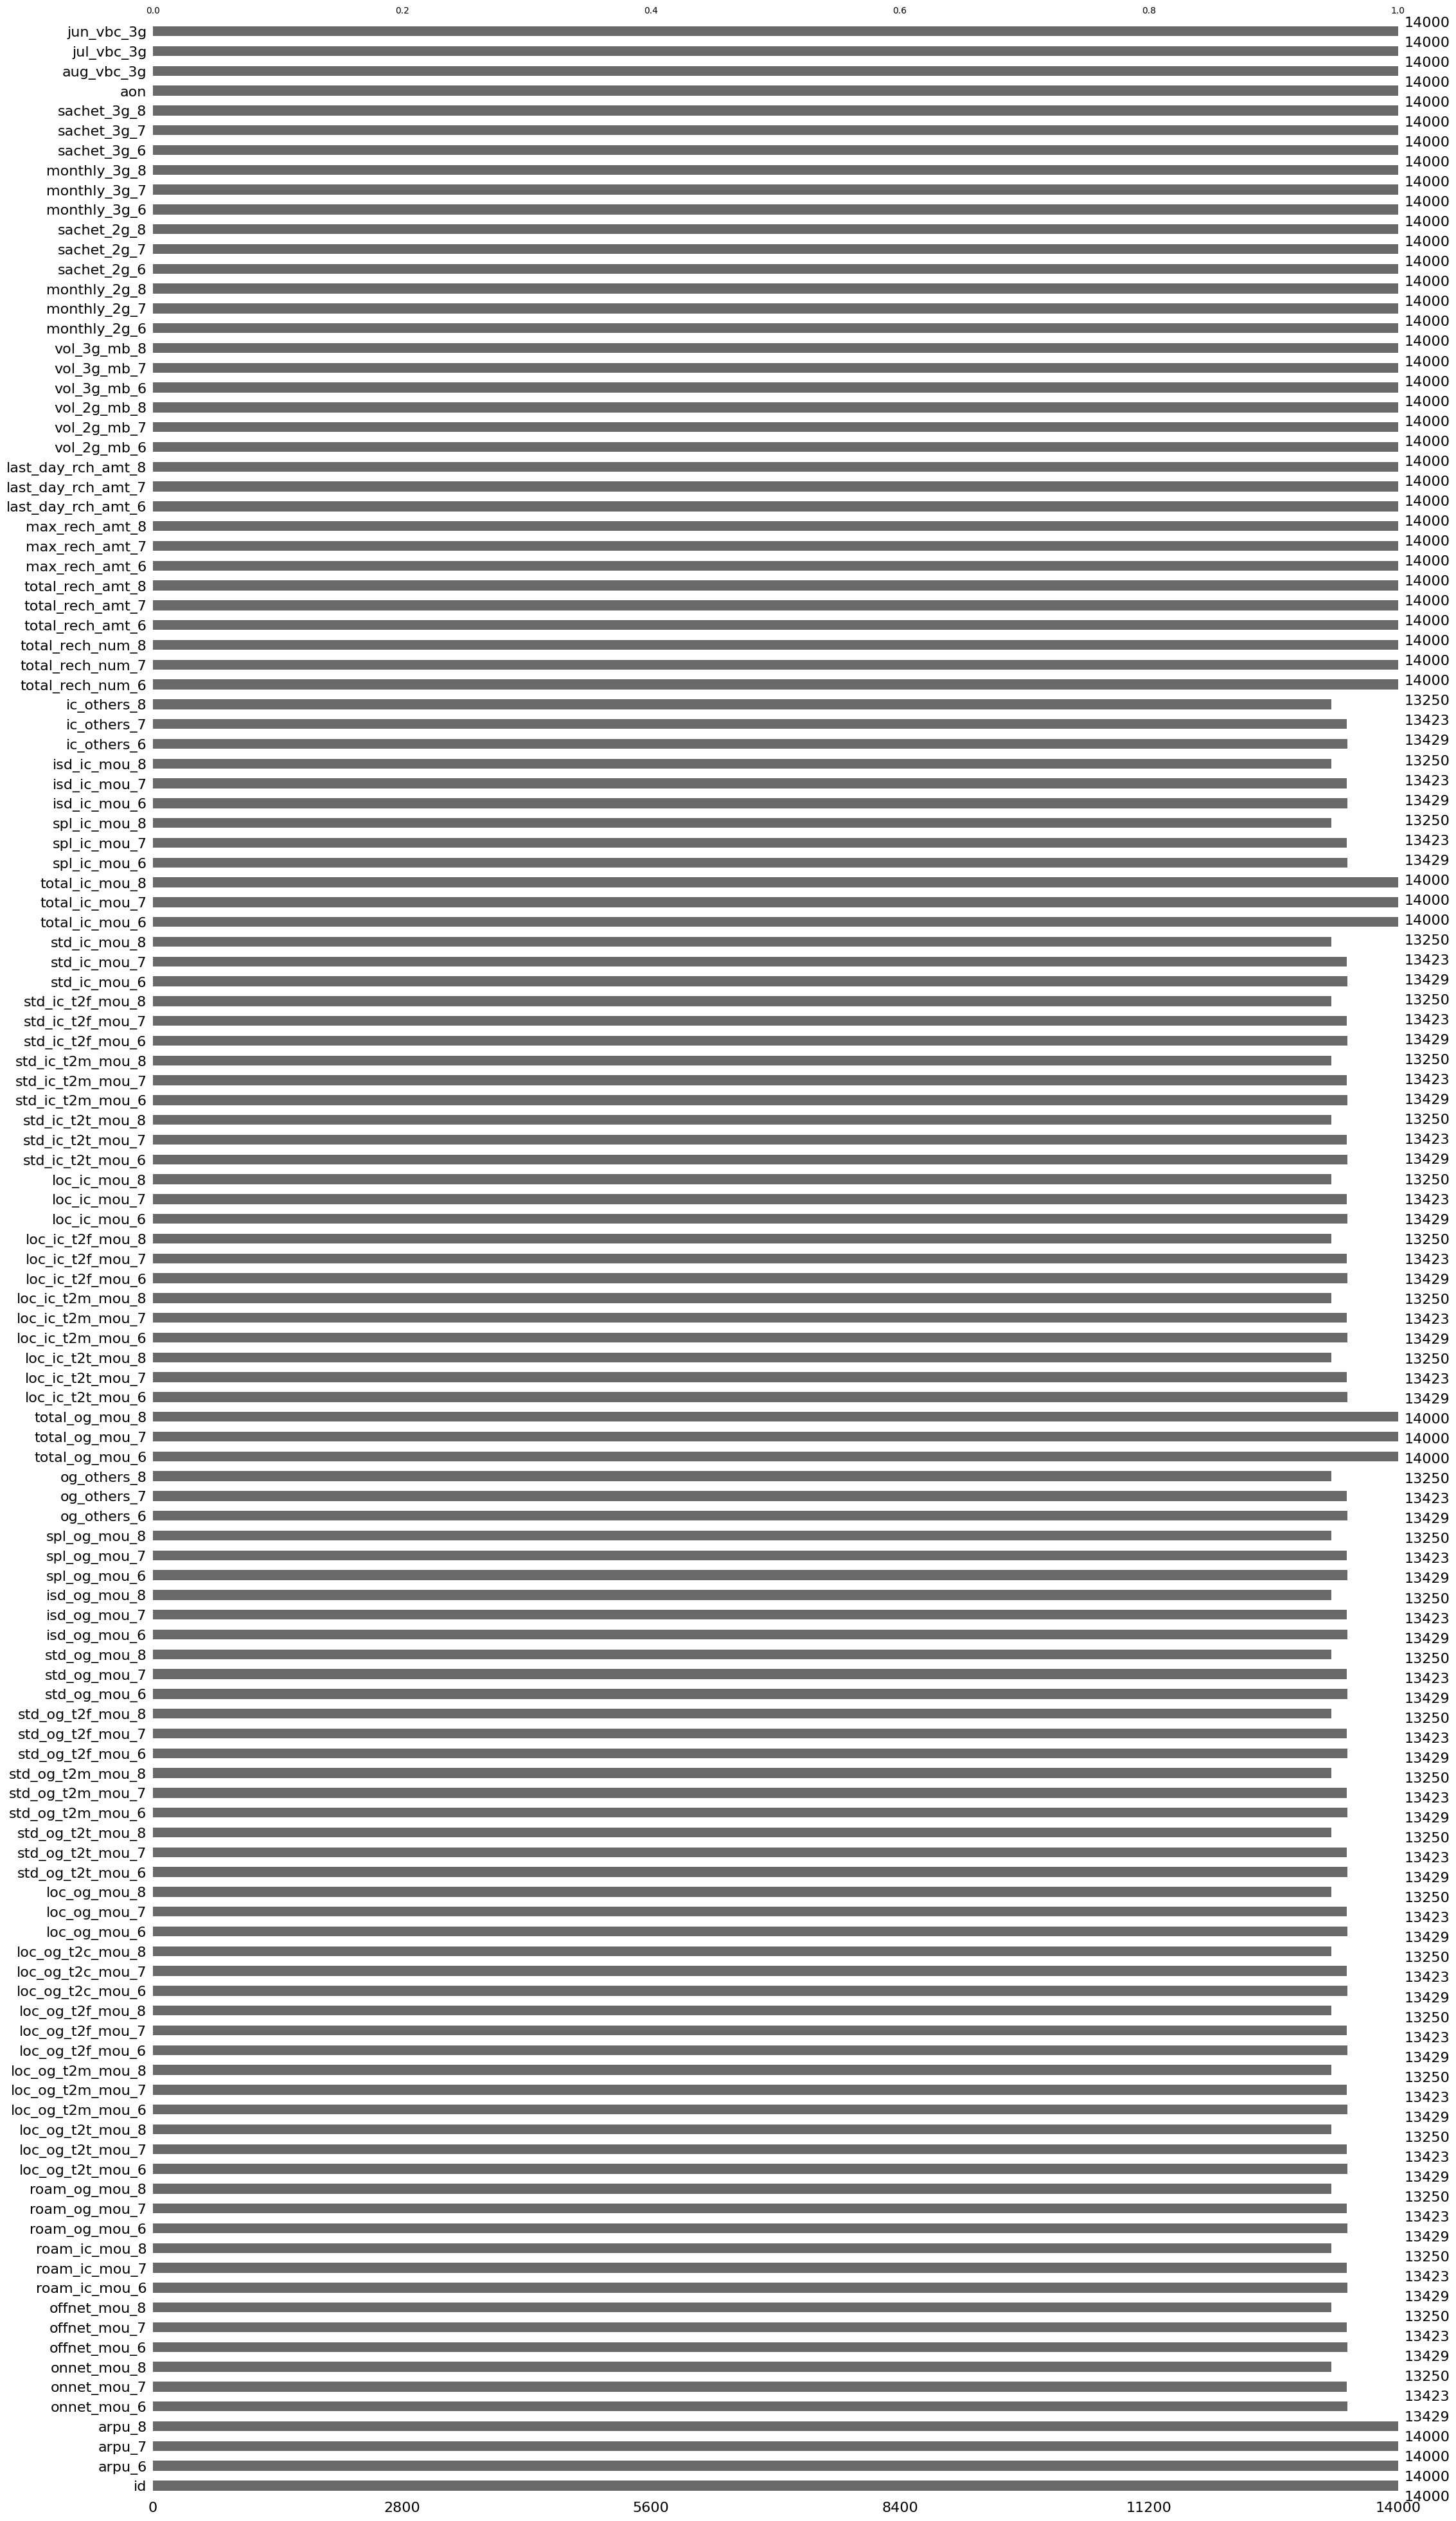

In [30]:
msno.bar(X_test)

In [31]:
missing_data_percent = X_test_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [32]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_test_filtered[impute_cols] = imp.fit_transform(X_test_filtered[impute_cols])

<Axes: >

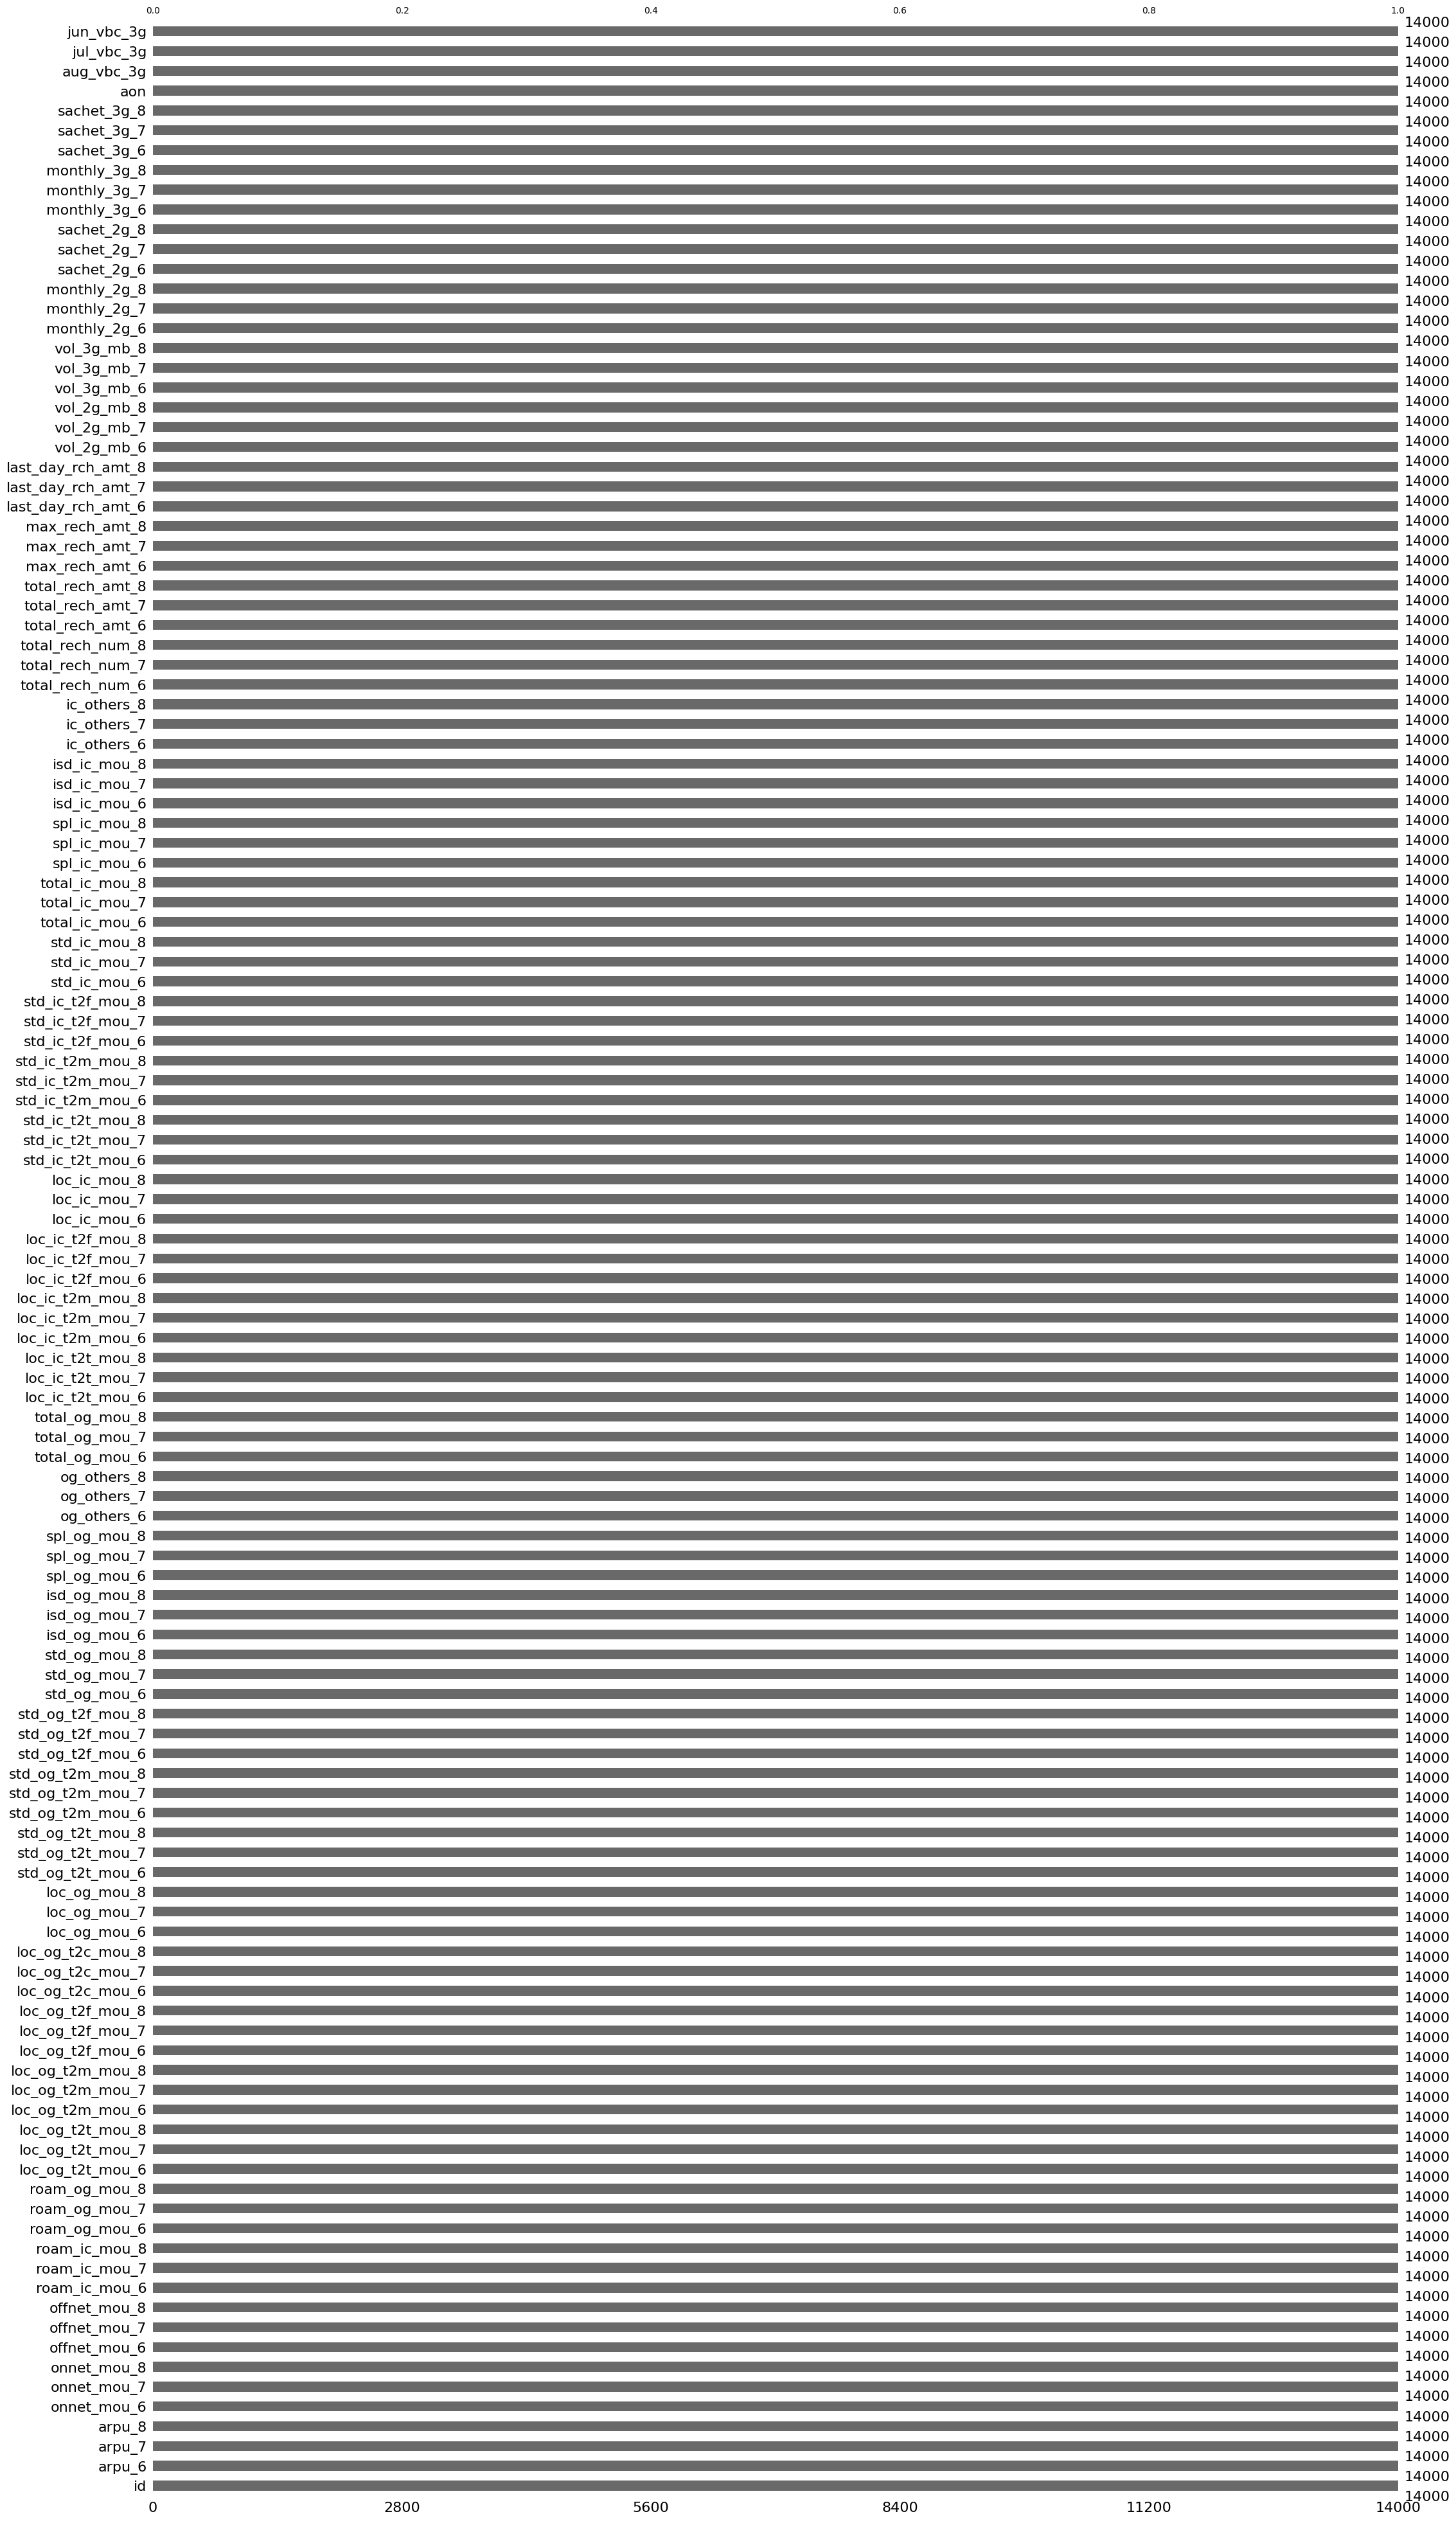

In [33]:
msno.bar(X_test_filtered)

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

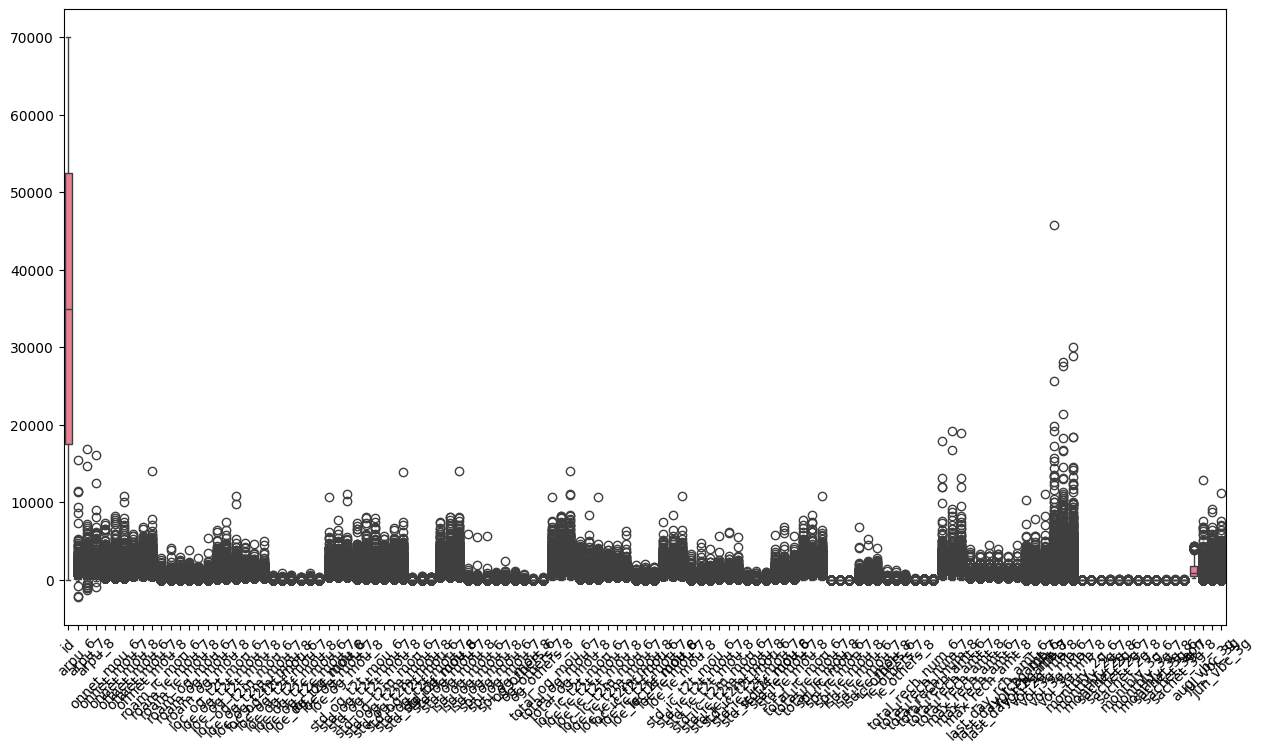

In [34]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [35]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

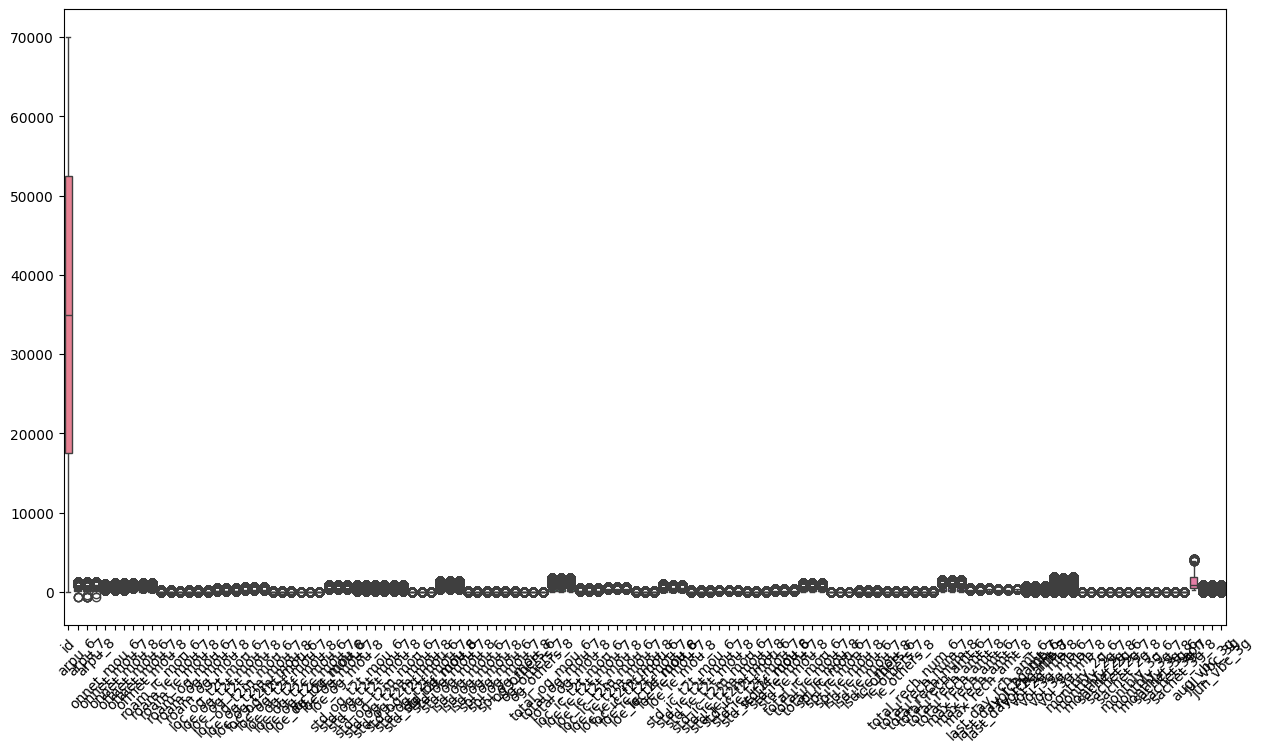

In [36]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [37]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<Axes: >

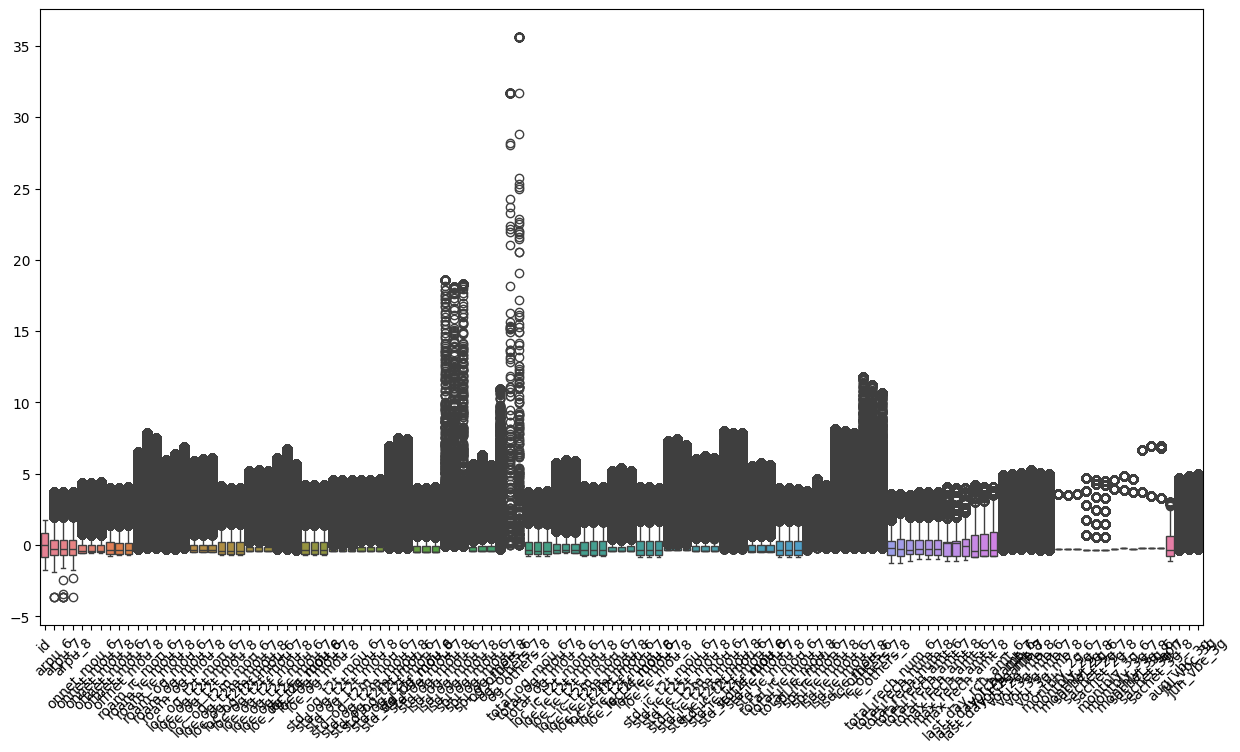

In [38]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

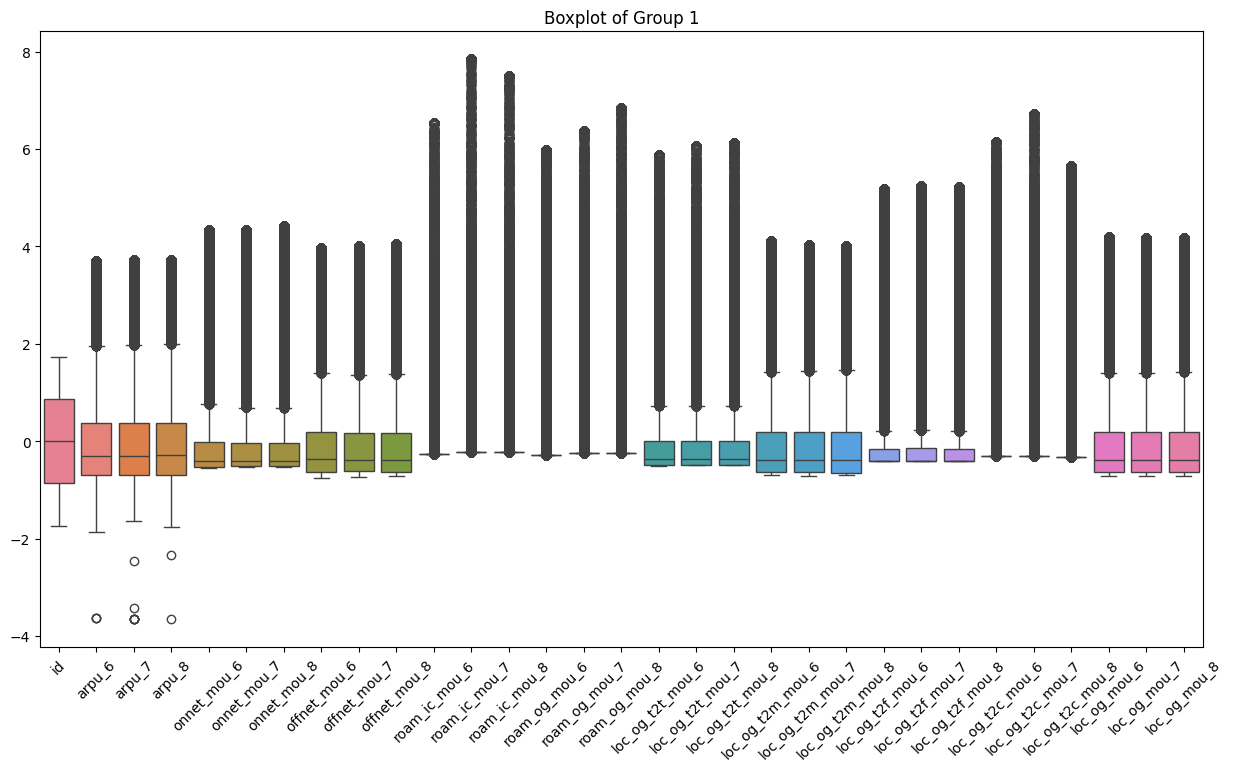

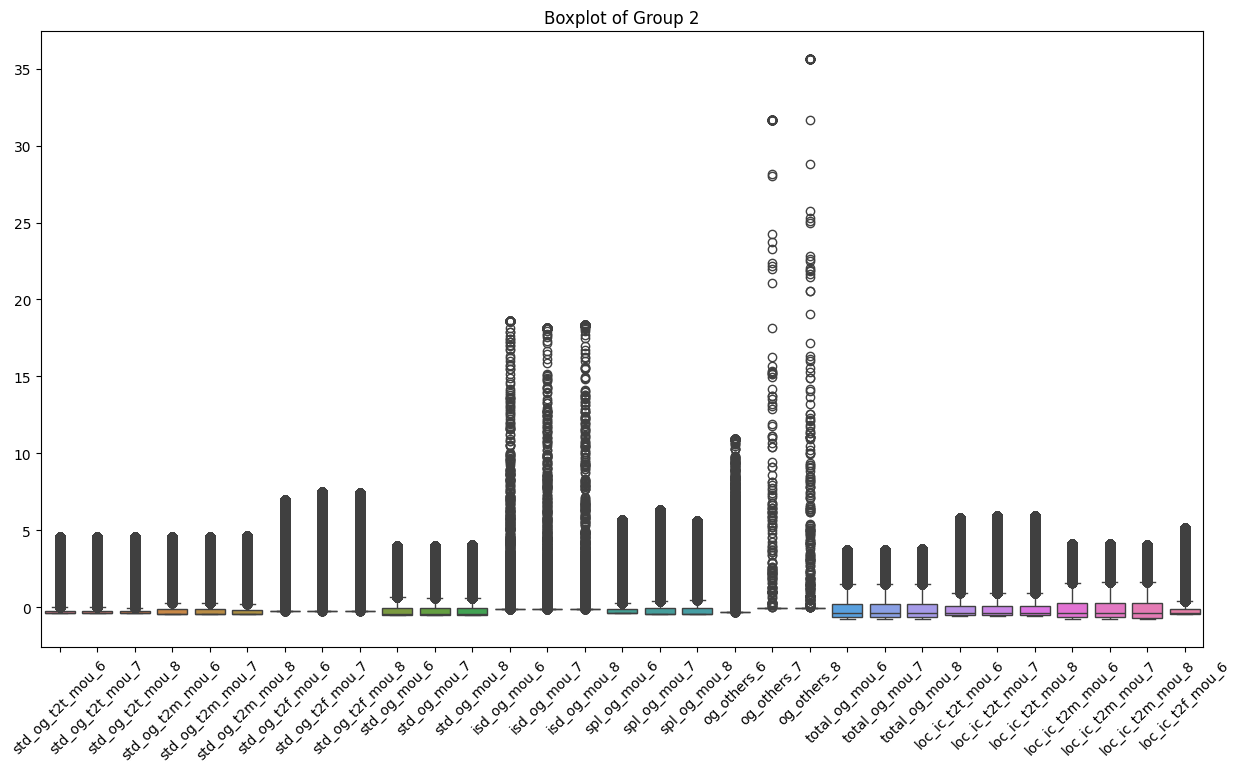

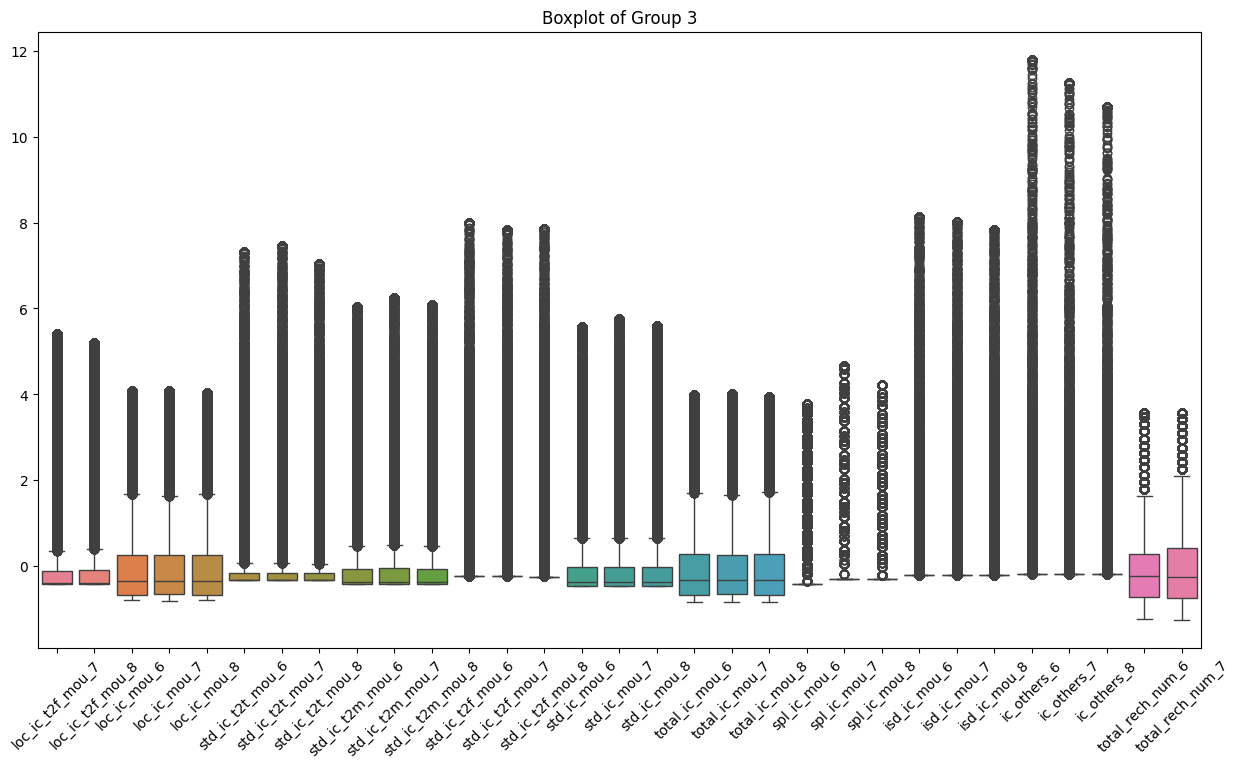

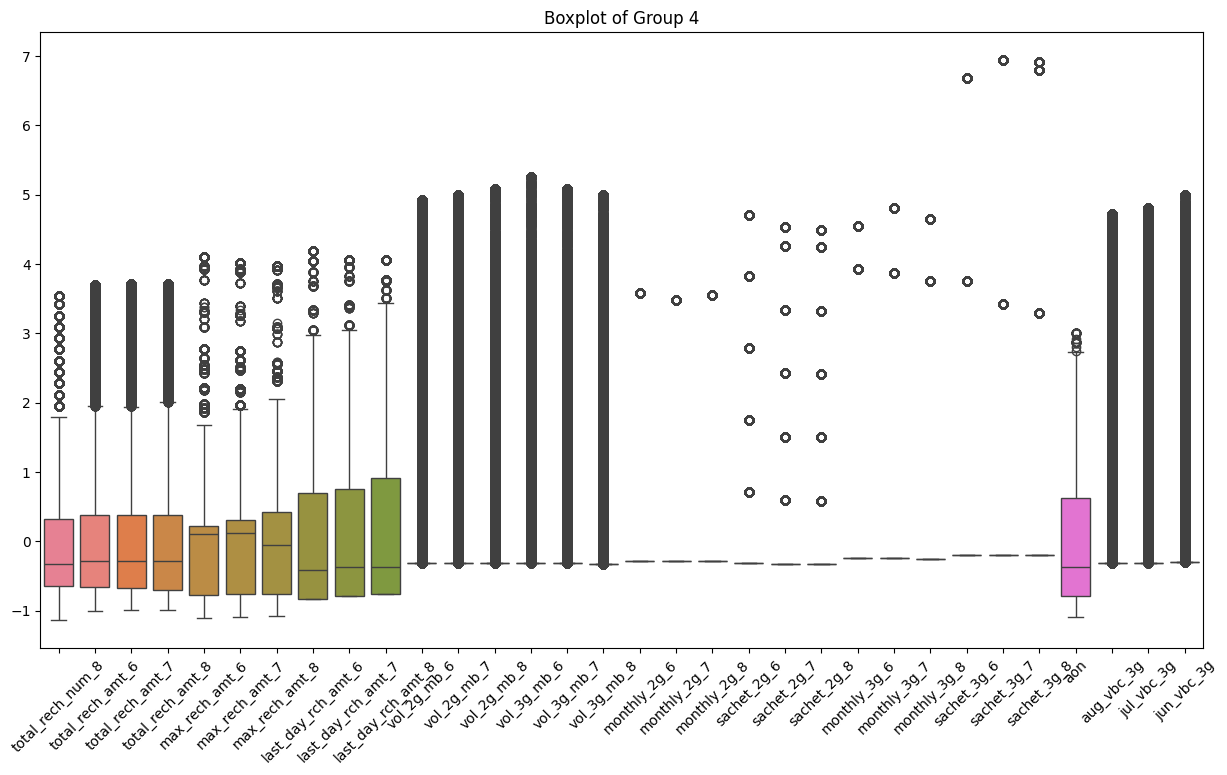

In [39]:
# Convert X_train_filtered2 to a DataFrame with column names from new_vars
X_train_filtered2_df = pd.DataFrame(X_train_filtered2, columns=new_vars)

# Define the number of groups
num_groups = 4
columns_per_group = len(new_vars) // num_groups

# Create separate boxplots for each group of columns
for i in range(num_groups):
    # Select the subset of columns for this group
    start = i * columns_per_group
    end = (i + 1) * columns_per_group if i != num_groups - 1 else len(new_vars)
    group_columns = new_vars[start:end]
    
    # Create the boxplot for the current group by selecting only the relevant columns
    plt.figure(figsize=(15, 8))
    plt.xticks(rotation=45)
    sns.boxplot(data=X_train_filtered2_df[group_columns])
    plt.title(f"Boxplot of Group {i + 1}")
    plt.show()

<Axes: >

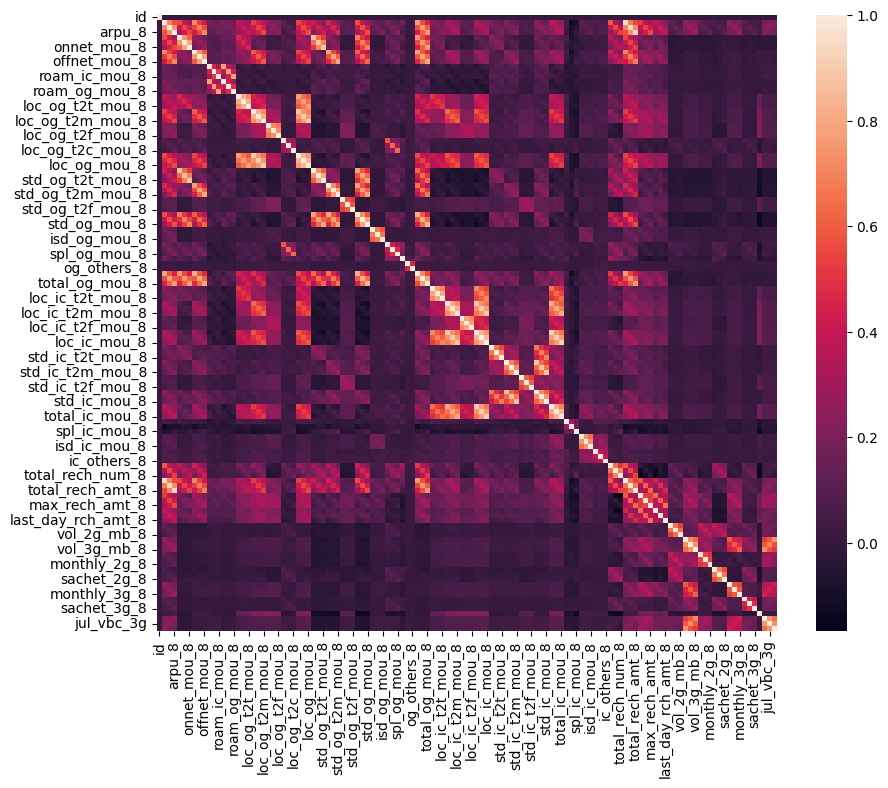

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

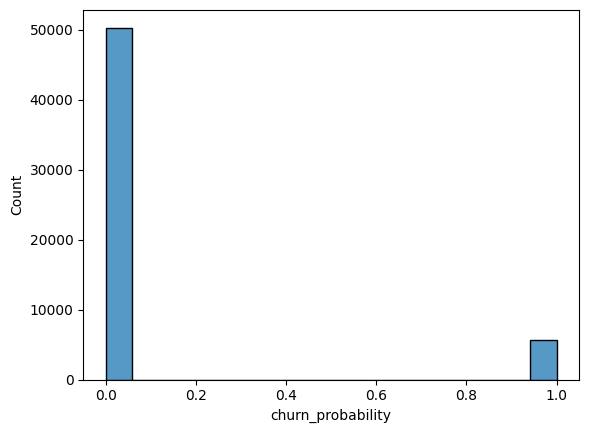

In [41]:
#Distribution for the churn probability
sns.histplot(y_train)

#### Same operation needs to be done for Unseen data as well @ Michel...........

In [42]:
#Segregating the train data for high value customers
## This needs to be done before Scaling ....
X_train_filtered.columns

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [43]:
X_train_filtered.shape

(55999, 125)

In [44]:
X_train_filtered.shape

(55999, 125)

In [45]:
y_train.value_counts()

0    50302
1     5697
Name: churn_probability, dtype: int64

In [46]:
y_test.value_counts()

0    12565
1     1435
Name: churn_probability, dtype: int64

<Axes: xlabel='churn_probability', ylabel='Count'>

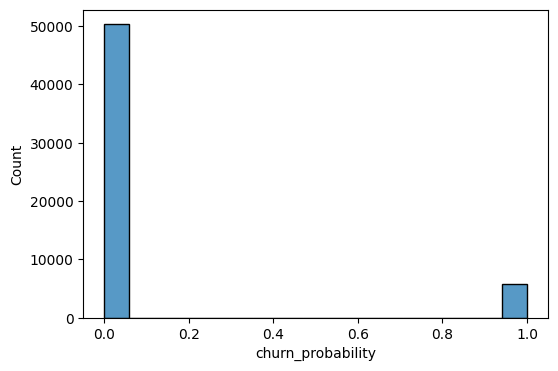

In [47]:
#Distribution for the churn probability
plt.figure(figsize=(6, 4))
sns.histplot(y_train)

In [50]:
from imblearn.over_sampling import SMOTE

In [52]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train_filtered2, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)


(100604, 125)
(100604,)
